In [2]:
pip install rpy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install ImbalancedLearningRegression

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76 kB 3.2 MB/s 
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=00954519fd148615cf5000770f5bb04b2d8f87d71dadcb44599d2ddff2a6c99c
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


In [4]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, GridSearchCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.pipeline import Pipeline

import seaborn
import matplotlib.pyplot as plt

import ImbalancedLearningRegression as iblr

from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [5]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage
from rpy2.robjects import default_converter
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import Converter, localconverter
import rpy2.robjects.numpy2ri

rpy2.robjects.numpy2ri.activate()
pandas2ri.activate()

In [7]:
string = """

U1 <- function(){

  install.packages("devtools")
  library(devtools)

  
  install.packages(c("operators", "class", "fields", "ROCR", "Hmisc", "performanceEstimation"))

  install.packages(c("zoo","xts","quantmod"))

  install.packages( "https://cran.r-project.org/src/contrib/Archive/DMwR/DMwR_0.4.1.tar.gz", repos=NULL, type="source")

  install_github("nunompmoniz/IRon")
  install_github("paobranco/UBL")
  install_github("rpribeiro/uba")

  library(uba)
  library(UBL)
  library(IRon)
  
}

"""
powerpack = SignatureTranslatedAnonymousPackage(string, "powerpack")

powerpack.U1()

(as ‘lib’ is unspecified)
























	‘/tmp/RtmpUrRaM3/downloaded_packages’

(as ‘lib’ is unspecified)
































	‘/tmp/RtmpUrRaM3/downloaded_packages’

(as ‘lib’ is unspecified)

















	‘/tmp/RtmpUrRaM3/downloaded_packages’

(as ‘lib’ is unspecified)






  Use `force = TRUE` to force installation

  Use `force = TRUE` to force installation





* checking for file ‘/tmp/RtmpUrRaM3/remotes3b5cd6946d/rpribeiro-uba-13333c6/DESCRIPTION’ ... OK
* preparing ‘uba’:
* checking DESCRIPTION meta-information ... OK
* cleaning src
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘uba_0.7.7.tar.gz’



(as ‘lib’ is unspecified)


Attaching package: ‘operators’



    options, strrep





Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’



    backsolve, forwardsolve




Try help(fields) to get started.





  method            from
  as.zoo.data.frame zoo 

Attaching package: ‘DMwR’



    unscale


Attaching package: ‘uba’



    subset









Attaching package: ‘UBL’



    phi, phi.control


Attaching package: ‘IRon’



    phi, phi.control



    phi, phi.control




'IRon','UBL','randomFo...,...,'datasets','methods','base'


In [8]:
uba = importr("uba")

In [9]:
dataset = pd.read_csv('https://raw.githubusercontent.com/JusciAvelino/Monitoria-ModelagemPreditivaDescritiva1/main/abalone.csv')

In [10]:
dataset

,Rings,Sex,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight
0,15,0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500
1,7,0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700
2,9,1,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100
3,10,0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550
4,7,2,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550
...,...,...,...,...,...,...,...,...,...
4172,11,1,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490
4173,10,0,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605
4174,9,0,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080
4175,10,1,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960


In [11]:
X = dataset.drop([dataset.columns[0]], axis = 1)
y = dataset[dataset.columns[0]]

In [12]:
pc = iblr.phi_ctrl_pts(y)
phi = iblr.phi(y, pc)
n=0
for idx, p in enumerate(phi):
    if p >= 0.8:
        n=n+1

l = dataset.shape[0]

print("Número de casos raros:", n)
print("Porcentagem de casos raros: %.1f" %(n/l*100))

Número de casos raros: 679
Porcentagem de casos raros: 16.3


In [13]:
def pipe_generation():
  clf_param = dict()
  for clf in [DecisionTreeRegressor(), MLPRegressor(max_iter=200), SVR()]:
      clf_param[str(clf).split('(')[0]] = clf

  pipes_params = []
  for clf,  param_grid in zip([DecisionTreeRegressor(), MLPRegressor(max_iter=200), SVR()],
                               
                  [{'clf__min_samples_split': [10, 20]},
                   {'clf__learning_rate_init': [0.1],'clf__momentum': (0.2, 0.7),'clf__tol': (0.01, 0.05)},
                   {'clf__gamma': [0.01, 0.001], 'clf__C': [10, 300]}]):

    configs = []
    clf = str(clf).split('(')[0]
    for p in param_grid:
        aux = p
        for i in param_grid[p]:
          aux += '+'+str(i)
        clf += '|'+aux
    configs.append(clf)
  
    for config in configs:
    
      pipeline = Pipeline([('clf', clf_param[config.split('|')[0]])])
      params = config.split('|')
    
      param_grid = {}
      t, t1 = len(params), 0
      for p in range(len(params)):
        values = ()
        if len(params[p].split('+')) > 2:
          a = params[p].split('+')[1:]
          for j in a:
            if '0.' in j:
              values += (float(j),)
            else:
              values += (int(j),)
          
          param_grid[params[p].split('+')[0]] = values
        
        else:
    
          if t1 == t:   
            if '0.' in params[p].split('+')[1]:
              param_grid[params[p].split('+')[0]] = [params[p].split('+')[1]]
            else:
              param_grid[params[p].split('+')[0]] = [params[p].split('+')[1]]
          elif t1 < t:
            for l in params[t1].split('+')[1:]:

              if '0.' in l:
                param_grid[params[t1].split('+')[0]] = [float(l)]
              else:
                param_grid[params[t1].split('+')[0]] = [int(l)]

        t1 += 1
  
    pipes_params.append([pipeline, param_grid]) 
  return pipes_params

In [22]:
def grid_Search(skf, pipeline=None, param_grid=None):
  mse_list = []
  f1_list = []
  fold = 0

  for train, test in skf.split(X, y):
        
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]
    
        grid = GridSearchCV(pipeline, cv=skf, param_grid=param_grid)

        grid.fit(X_train, y_train)

        y_pred = grid.predict(X_test)


        ph = uba.phi_control(y_test)
        ls = uba.loss_control(y_test)

        F1 = uba.util(y_pred, y_test, ph, ls, uba.util_control(umetric="Fm", beta=1, event_thr=0.8))

        print("Melhor parametro:", grid.best_params_)         
        print("Fold %d" %(fold))
        print("MSE: %.3f" %(mean_squared_error(y_test, y_pred))) 
        print("F1-score: ", F1.round(3)[0])
        
        mse_list.append(mean_squared_error(y_test, y_pred))
        f1_list.append(F1)

        fold += 1   
    
  mse = np.array(mse_list)
  f1  = np.array(f1_list)
  print("\nMSE (desvio): %.3f +- (%.3f)" %(mse.mean(), mse.std()))
  print("\nF1 (desvio): %.3f +- (%.3f)" %(f1.mean(), f1.std()))
  print("\n")

In [23]:
pipes_params = pipe_generation()  

for j in pipes_params:
    pipeline, param_grid = j[0], j[1]
    print(str(pipeline.steps[0][1]).split('(')[0])
    grid_Search(KFold(n_splits=5, random_state=42, shuffle=True), pipeline=pipeline, param_grid=param_grid)

DecisionTreeRegressor
Melhor parametro: {'clf__min_samples_split': 20}
Fold 0
MSE: 7.046
F1-score:  0.638
Melhor parametro: {'clf__min_samples_split': 20}
Fold 1
MSE: 6.498
F1-score:  0.593
Melhor parametro: {'clf__min_samples_split': 20}
Fold 2
MSE: 6.962
F1-score:  0.603
Melhor parametro: {'clf__min_samples_split': 20}
Fold 3
MSE: 7.757
F1-score:  0.553
Melhor parametro: {'clf__min_samples_split': 20}
Fold 4
MSE: 5.777
F1-score:  0.56

MSE (desvio): 6.808 +- (0.654)

F1 (desvio): 0.589 +- (0.031)


MLPRegressor
Melhor parametro: {'clf__learning_rate_init': 0.1, 'clf__momentum': 0.2, 'clf__tol': 0.05}
Fold 0
MSE: 5.043
F1-score:  0.693
Melhor parametro: {'clf__learning_rate_init': 0.1, 'clf__momentum': 0.2, 'clf__tol': 0.01}
Fold 1
MSE: 5.048
F1-score:  0.639
Melhor parametro: {'clf__learning_rate_init': 0.1, 'clf__momentum': 0.2, 'clf__tol': 0.05}
Fold 2
MSE: 5.459
F1-score:  0.63
Melhor parametro: {'clf__learning_rate_init': 0.1, 'clf__momentum': 0.2, 'clf__tol': 0.05}
Fold 3
MSE: 5

**IMBALANCED REGRESSION**

In [24]:
ds_ro = iblr.ro(  
    data = dataset, 
    y = 'Rings', 
    rel_thres = 0.8
)

r_index: 100%|##########| 901/901 [00:00<00:00, 3407.18it/s]


In [25]:
dataset.shape

(4177, 9)

In [26]:
ds_ro.shape

(6280, 9)

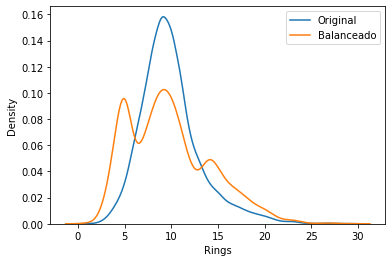

In [27]:
seaborn.kdeplot(dataset['Rings'], label = "Original")
seaborn.kdeplot(ds_ro['Rings'], label = "Balanceado")
plt.legend(labels=["Original","Balanceado"])

In [28]:
def grid_Search_resample(skf, pipeline=None, param_grid=None):
  mse_list = []
  f1_list = []
  
  fold = 0


  for train_index, test_index in skf.split(X, y):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        train = np.column_stack((y_train, X_train))
        pd.DataFrame(train).to_csv("train.csv", index=False)
        train = pd.read_csv("/content/train.csv")

        ds_ro = iblr.ro(
          data = train, 
          y = '0',
          rel_thres = 0.8
        )
    
        print("Original", train.shape)
        print("Modificado", ds_ro.shape)
        
        X_train = ds_ro.drop([ds_ro.columns[0]], axis = 1)
        y_train  = ds_ro[ds_ro.columns[0]]

        grid = GridSearchCV(pipeline, cv=skf, param_grid=param_grid)

        grid.fit(X_train, y_train)

        y_pred = grid.predict(X_test)

        ph = uba.phi_control(y_test)
        ls = uba.loss_control(y_test)

        F1 = uba.util(y_pred, y_test, ph, ls, uba.util_control(umetric="Fm", beta=1, event_thr=0.8))

        print("Melhor parametro:", grid.best_params_)         
        print("Fold %d" %(fold))
        print("MSE: %.3f" %(mean_squared_error(y_test, y_pred))) 
        print("F1-score", F1.round(3)[0])
        
        mse_list.append(mean_squared_error(y_test, y_pred))
        f1_list.append(F1)

        fold += 1   
    
  mse = np.array(mse_list)
  f1  = np.array(f1_list)
  print("\nMSE (desvio): %.3f +- (%.3f)" %(mse.mean(), mse.std()))
  print("\nF1 (desvio): %.3f +- (%.3f)" %(f1.mean(), f1.std()))
  print("\n")

In [29]:
pipes_params = pipe_generation()  

for j in pipes_params:
    pipeline, param_grid = j[0], j[1]
    print(str(pipeline.steps[0][1]).split('(')[0])
    grid_Search_resample(KFold(n_splits=5, random_state=42, shuffle=True), pipeline=pipeline, param_grid=param_grid)

DecisionTreeRegressor


r_index: 100%|##########| 725/725 [00:00<00:00, 3215.76it/s]


Original (3341, 9)
Modificado (5038, 9)
Melhor parametro: {'clf__min_samples_split': 10}
Fold 0
MSE: 9.373
F1-score 0.615


r_index: 100%|##########| 704/704 [00:00<00:00, 3255.26it/s]


Original (3341, 9)
Modificado (5009, 9)
Melhor parametro: {'clf__min_samples_split': 10}
Fold 1
MSE: 7.663
F1-score 0.595


r_index: 100%|##########| 729/729 [00:00<00:00, 3455.75it/s]


Original (3342, 9)
Modificado (5038, 9)
Melhor parametro: {'clf__min_samples_split': 10}
Fold 2
MSE: 9.608
F1-score 0.54


r_index: 100%|##########| 742/742 [00:00<00:00, 3626.12it/s]


Original (3342, 9)
Modificado (5040, 9)
Melhor parametro: {'clf__min_samples_split': 10}
Fold 3
MSE: 9.225
F1-score 0.606


r_index: 100%|##########| 707/707 [00:00<00:00, 3672.88it/s]


Original (3342, 9)
Modificado (5002, 9)
Melhor parametro: {'clf__min_samples_split': 10}
Fold 4
MSE: 6.969
F1-score 0.6

MSE (desvio): 8.567 +- (1.052)

F1 (desvio): 0.591 +- (0.026)


MLPRegressor


r_index: 100%|##########| 725/725 [00:00<00:00, 3747.67it/s]


Original (3341, 9)
Modificado (5038, 9)
Melhor parametro: {'clf__learning_rate_init': 0.1, 'clf__momentum': 0.2, 'clf__tol': 0.01}
Fold 0
MSE: 4.642
F1-score 0.74


r_index: 100%|##########| 704/704 [00:00<00:00, 3469.18it/s]


Original (3341, 9)
Modificado (5009, 9)
Melhor parametro: {'clf__learning_rate_init': 0.1, 'clf__momentum': 0.7, 'clf__tol': 0.01}
Fold 1
MSE: 7.590
F1-score 0.664


r_index: 100%|##########| 729/729 [00:00<00:00, 3399.29it/s]


Original (3342, 9)
Modificado (5038, 9)
Melhor parametro: {'clf__learning_rate_init': 0.1, 'clf__momentum': 0.7, 'clf__tol': 0.01}
Fold 2
MSE: 5.130
F1-score 0.687


r_index: 100%|##########| 742/742 [00:00<00:00, 2983.64it/s]


Original (3342, 9)
Modificado (5040, 9)
Melhor parametro: {'clf__learning_rate_init': 0.1, 'clf__momentum': 0.7, 'clf__tol': 0.01}
Fold 3
MSE: 6.524
F1-score 0.677


r_index: 100%|##########| 707/707 [00:00<00:00, 3584.45it/s]


Original (3342, 9)
Modificado (5002, 9)
Melhor parametro: {'clf__learning_rate_init': 0.1, 'clf__momentum': 0.2, 'clf__tol': 0.05}
Fold 4
MSE: 4.379
F1-score 0.645

MSE (desvio): 5.653 +- (1.219)

F1 (desvio): 0.683 +- (0.032)


SVR


r_index: 100%|##########| 725/725 [00:00<00:00, 3719.97it/s]


Original (3341, 9)
Modificado (5038, 9)
Melhor parametro: {'clf__C': 300, 'clf__gamma': 0.01}
Fold 0
MSE: 5.192
F1-score 0.722


r_index: 100%|##########| 704/704 [00:00<00:00, 3386.53it/s]


Original (3341, 9)
Modificado (5009, 9)
Melhor parametro: {'clf__C': 300, 'clf__gamma': 0.01}
Fold 1
MSE: 4.775
F1-score 0.641


r_index: 100%|##########| 729/729 [00:00<00:00, 3354.46it/s]


Original (3342, 9)
Modificado (5038, 9)
Melhor parametro: {'clf__C': 300, 'clf__gamma': 0.01}
Fold 2
MSE: 5.517
F1-score 0.678


r_index: 100%|##########| 742/742 [00:00<00:00, 3270.01it/s]


Original (3342, 9)
Modificado (5040, 9)
Melhor parametro: {'clf__C': 300, 'clf__gamma': 0.01}
Fold 3
MSE: 5.189
F1-score 0.671


r_index: 100%|##########| 707/707 [00:00<00:00, 3800.42it/s]


Original (3342, 9)
Modificado (5002, 9)
Melhor parametro: {'clf__C': 300, 'clf__gamma': 0.01}
Fold 4
MSE: 4.246
F1-score 0.682

MSE (desvio): 4.984 +- (0.438)

F1 (desvio): 0.679 +- (0.026)




**Sem balanceamento**


**DT**

MSE (desvio): 6.808 +- (0.654)

F1 (desvio): 0.589 +- (0.031)

**MLP**

MSE (desvio): 4.984 +- (0.426)

F1 (desvio): 0.651 +- (0.024)

**SVM**

MSE (desvio): 4.966 +- (0.588)

F1 (desvio): 0.626 +- (0.045)


**Após balanceamento**

**DT**

MSE (desvio): 8.567 +- (1.052)

F1 (desvio): 0.591 +- (0.026)

**MLP**

MSE (desvio): 5.653 +- (1.219)

F1 (desvio): 0.683 +- (0.032)

**SVM**

MSE (desvio): 4.984 +- (0.438)

F1 (desvio): 0.679 +- (0.026)

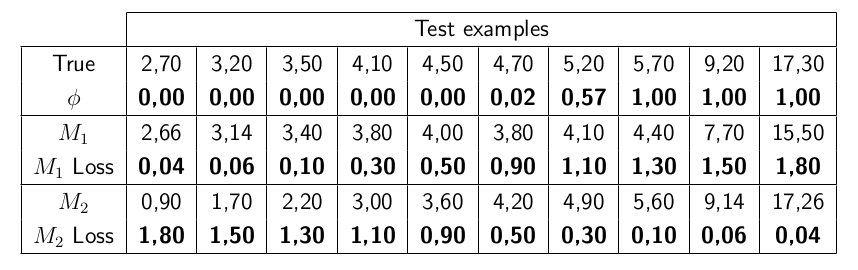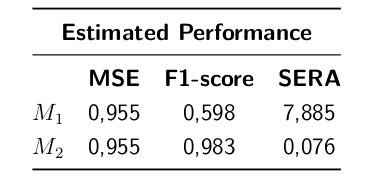